In [2]:
from utils import *

In [3]:
if torch.cuda.is_available():
    DEVICE = "cuda:1"
else:
    DEVICE = "cpu"

### Models and Reward function

In [30]:
class LSTMModel_1(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel_1, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True,
            bias=True,
            dropout=0.0,
        )

        self.fc_1 = nn.Sequential(
            nn.Linear(11, 1),
        )

        self.fc_2 = nn.Sequential(
            nn.Linear(hidden_size // 1, hidden_size // 2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 4, hidden_size // 8),
            nn.LeakyReLU(),
            nn.Dropout1d(0.0),
            nn.Linear(hidden_size // 8, output_size),
        )

        self.fc_b = nn.Linear(input_size - 69, input_size)

        # self.sigmoid  = nn.Sigmoid()

    def forward(self, x, x_2023):
        out = self.fc_1(x)
        out = out[..., 0]

        x_2023 = self.fc_b(x_2023)[:, None, ...]
        out = torch.cat([out, x_2023], dim=1)

        out, _ = self.lstm(out)
        out = out[:, -1, ...]

        out = self.fc_2(out)

        # out = self.sigmoid(out)

        return out
    


In [33]:
def Reward(outputs, price):
    reward = outputs * price
    return reward

### Creating model, loading weights and data

In [43]:
model1 = LSTMModel_1(74, 512, 5, 1).to(device=DEVICE).eval()
model1.load_state_dict(
    torch.load("./models/without_stellensubart.pth")
);

### Optimization step for neighboours and qids

In [44]:
data_X = torch.split(
    torch.load("data/X_val_1000_without_stellensubart.pt")
    .permute(0, 1, 3, 2)
    .to(torch.float32),
    1,
)

data_x = torch.split(
    torch.load("data/x_val_1000_without_stellensubart.pt").to(torch.float32), 1
)

In [45]:
price_mean, price_std = (21.230517726667767, 13.387471717906585)
M = len(data_X)
N = 1000
history = np.zeros((M, 3, N))

for i, (sample_X, sample_x) in tqdm(enumerate(zip(data_X, data_x)), total=1000):
    for j, price in enumerate(np.linspace(0, 100, N)):
        sample_x[0, -5] = (price - price_mean) / price_std
        mean_b = model1(sample_X.to(DEVICE), sample_x.to(DEVICE))
        reward = Reward(price, mean_b)

        history[i, 0, j] = price
        history[i, 1, j] = mean_b
        history[i, 2, j] = reward


100%|███████████████████████████████████████| 1000/1000 [13:16<00:00,  1.26it/s]


In [46]:
test_qids = np.load("../data/val_qids_1000.npy")
test_qids.sort()

data = pd.read_pickle("../data/decade_price_data_combined_01_09.pkl")
data = data[data.GJ == 2023]
data.sort_values(by="Qid", inplace=True)

qid_data = pd.DataFrame(columns=["Qid", "Preis", "Optimal_preis", "Min_optimal_preis", "Max_optimal_preis"])

qid_data["Qid"] = test_qids
qid_data["Preis"] = data[data.Qid.isin(test_qids)].Preis.values

new_history = {}
new_history_plot = {}

def find_nearest(array, value, idxis=False):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if idxis:
        return idx
    return array[idx]
 
for k, qid in enumerate(test_qids):
    try:
        peak_ids = scipy.signal.find_peaks(history[k, 2])[0]
        prices = history[k, 0, peak_ids]
        optim_price = find_nearest(prices, data[data.Qid == qid].Preis.values)
        margin = optim_price * 0.05
        new_history[qid] = [optim_price-margin, optim_price, optim_price+margin]
        ids = find_nearest(optim_price, data[data.Qid == qid].Preis.values, True)  

        new_history_plot[qid] = peak_ids[ids]
    except:
        new_history[qid] = [np.nan, np.nan, np.nan]
        new_history_plot[qid] = 0 
        

### Plot of reward func and optimal price range

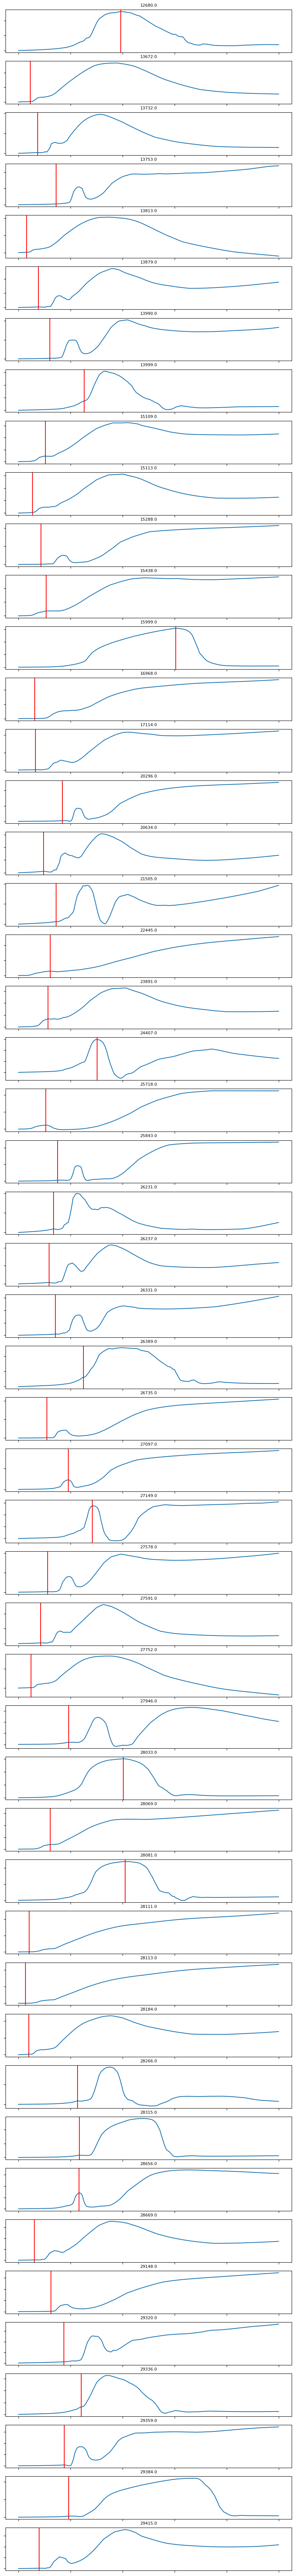

In [12]:
# With Stellensubart
fig, ax = plt.subplots(history[:50].shape[0], figsize=(10, 90))
    
for j in range(history[:50].shape[0]):
    ax[j].plot(history[j, -1, :])
    if list(new_history_plot.values())[j]:
        ax[j].axvline(list(new_history_plot.values())[j], color="red")
    ax[j].set_title(list(new_history_plot.keys())[j], fontsize=8)
    ax[j].set_yticklabels([])
    ax[j].set_xticklabels([])

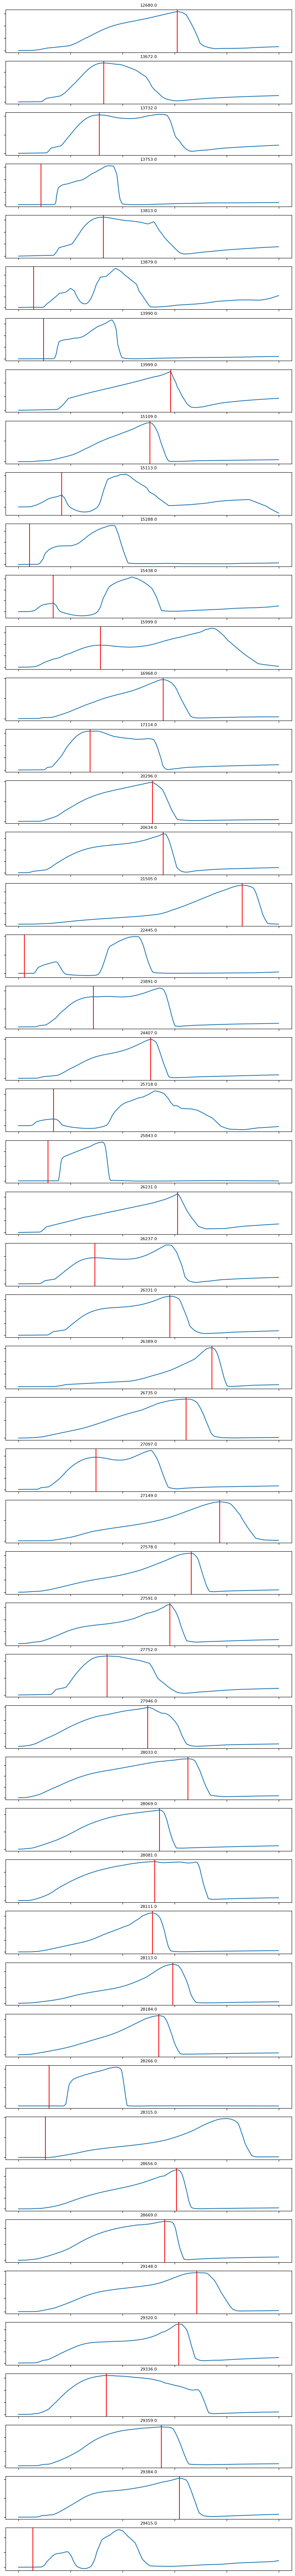

In [47]:
#Without Stellensubart
fig, ax = plt.subplots(history[:50].shape[0], figsize=(10, 90))
    
for j in range(history[:50].shape[0]):
    ax[j].plot(history[j, -1, :])
    if list(new_history_plot.values())[j]:
        ax[j].axvline(list(new_history_plot.values())[j], color="red")
    ax[j].set_title(list(new_history_plot.keys())[j], fontsize=8)
    ax[j].set_yticklabels([])
    ax[j].set_xticklabels([])

### Prepairing and saving optimal price with different sheets based on 4 qids

In [48]:
for j, qid in enumerate(test_qids):
    qid_data.iloc[j, 2] = new_history[qid][1]
    qid_data.iloc[j, 3] = new_history[qid][0]
    qid_data.iloc[j, 4] = new_history[qid][2]

In [14]:
# With Stellensubart
qid_data

,Qid,Preis,Optimal_preis,Min_optimal_preis,Max_optimal_preis
0,12680.0,38.6,39.339339,37.372372,41.306306
1,13672.0,12.0,9.209209,8.748749,9.66967
2,13732.0,16.4,14.114114,13.408408,14.81982
3,13753.0,22.1,23.123123,21.966967,24.279279
4,13813.0,10.9,6.606607,6.276276,6.936937
...,...,...,...,...,...
995,417399.0,15.2,15.315315,14.54955,16.081081
996,417667.0,56.0,68.668669,65.235235,72.102102
997,418527.0,18.8,19.019019,18.068068,19.96997
998,420114.0,59.6,68.868869,65.425425,72.312312


In [49]:
# without Stellensubart
qid_data

,Qid,Preis,Optimal_preis,Min_optimal_preis,Max_optimal_preis
0,12680.0,38.6,60.960961,57.912913,64.009009
1,13672.0,12.0,32.732733,31.096096,34.369369
2,13732.0,16.4,31.031031,29.479479,32.582583
3,13753.0,22.1,34.634635,32.902903,36.366366
4,13813.0,10.9,32.632633,31.001001,34.264264
...,...,...,...,...,...
995,417399.0,15.2,53.453453,50.780781,56.126126
996,417667.0,56.0,73.273273,69.60961,76.936937
997,418527.0,18.8,17.417417,16.546547,18.288288
998,420114.0,59.6,72.472472,68.848849,76.096096


In [50]:
with pd.ExcelWriter('../optimal_preis_1000_model1_without_Stellensubart.xlsx') as writer:
    qid_data.to_excel(writer, index=False)  